In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.decomposition import PCA

# load data
lp = '/data2/users/kperks/'
sp = 'ecog_center_out/'
input_file = 'new_data_lfp_mocap_rot.npy'

data = np.load(lp+input_file, allow_pickle=True)
data = data.item()
ecog = data['lfp']
pose = data['mocap']
recording_day = data['events']
times = data['time']

labels = ecog[:,-1,0]
assert (labels == pose[:,-1,0]).all()
n_targets = len(np.unique(labels))

# load model outputs
rootpth = './xdc_runs/'
dat_type = 'train' # 'train', test'
dataset = 'center_out'
sbjs_all = ['BEIG0414g']
subfolders_d = {'center_out': ['center_out_sup_run16']}
datasets = [dataset]

for i, dst in enumerate(datasets):
    subfolders = subfolders_d[dst]
    for i, fold in enumerate(subfolders):
        for j, sbj in enumerate(sbjs_all):
            # load model predictions
            fID = rootpth + fold + '/' +sbj + '_preds' + '.npy'
            if os.path.exists(fID):
                print(fID)
                preds_data = np.load(fID,allow_pickle=True).item()
            else:
                preds_data = None
            print(preds_data.keys())
            
            # load model probabilities
            fID = rootpth + fold + '/' +sbj + '_probs' + '.npy'
            if os.path.exists(fID):
                print(fID)
                probs_data = np.load(fID,allow_pickle=True).item()
            else:
                probs_data = None
            print(probs_data.keys())

train_inds = probs_data['train_split']
test_inds = probs_data['test_split']
train_true = preds_data['true_train']
train_pred = preds_data['pred_train']
test_true = preds_data['true_test']
test_pred = preds_data['pred_test']

train_smout = probs_data['softmax_output_train']
test_smout = probs_data['softmax_output_test']
print(len(train_inds), train_smout[0].shape, test_smout[0].shape)

assert train_smout[0].shape[0] == test_smout[0].shape[0]
n_modalities = train_smout[0].shape[0]
assert len(train_inds) == len(test_inds) == len(train_smout) == len(test_smout)
n_folds = len(train_inds)
assert train_smout[0].shape[-1] == test_smout[0].shape[-1]
n_cl = train_smout[0].shape[-1]
print(n_modalities, 'modalities,', n_folds, 'folds,', n_cl, 'classes')

./xdc_runs/center_out_sup_run16/BEIG0414g_preds.npy
dict_keys(['train_split', 'test_split', 'true_train', 'pred_train', 'true_test', 'pred_test'])
./xdc_runs/center_out_sup_run16/BEIG0414g_probs.npy
dict_keys(['train_split', 'test_split', 'softmax_output_train', 'softmax_output_test'])
10 (2, 410, 8) (2, 46, 8)
2 modalities, 10 folds, 8 classes


In [35]:
j = 1 # modality [neural, pose]
f = 1 # fold
curr_train_true = train_true[f][j,...]
curr_train_pred = train_pred[f][j,...]
curr_train_smout = train_smout[f][j,...]
print(curr_train_true.shape, curr_train_smout.shape)

print((np.argmax(curr_train_smout,axis=1) == curr_train_pred).all())

for t in range(n_cl):
    print(len(np.where(np.argmax(curr_train_smout,axis=1) == t)[0]), len(np.where(curr_train_pred == t)[0]), len(np.where(curr_train_true == t)[0]))

(410,) (410, 8)
True
49 49 51
45 45 52
54 54 51
52 52 51
63 63 52
47 47 51
49 49 51
51 51 51


(410, 8)
(410, 2)


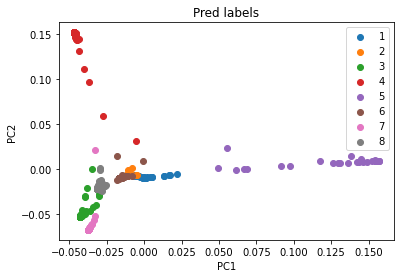

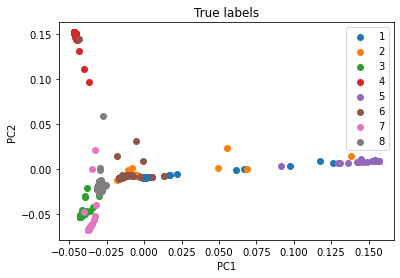

In [36]:
# EACH FOLD
j = 1 # modality [neural, pose]
f = 1 # fold
curr_train_true = train_true[f][j,...]
curr_train_pred = train_pred[f][j,...]
curr_train_smout = train_smout[f][j,...]

X = curr_train_smout
print(X.shape)
pca = PCA(n_components=2).fit(X)
pca_2d = pca.transform(X)
print(pca_2d.shape)

cl_labels = curr_train_pred # same as np.argmax(curr_train_smout,axis=1)
plt.figure()
for i in range(n_cl):
    ind = np.where(cl_labels==i)
    plt.scatter(pca_2d[ind,0], pca_2d[ind,1], label=str(i+1))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('Pred labels')

cl_labels = curr_train_true
plt.figure()
for i in range(n_cl):
    ind = np.where(cl_labels==i)
    plt.scatter(pca_2d[ind,0], pca_2d[ind,1], label=str(i+1))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('True labels');

(4104, 8)
(4104, 2)


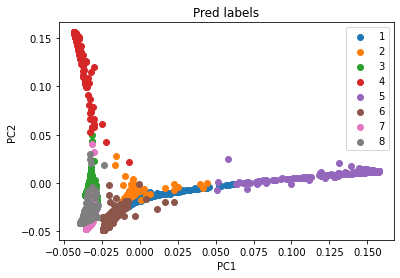

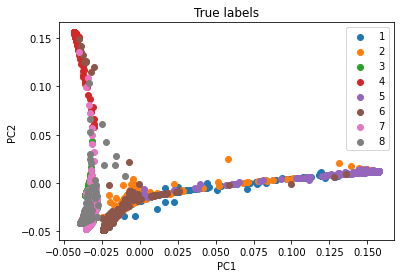

In [37]:
# OVER ALL FOLDS
j = 1 # modality [neural, pose]
curr_train_true, curr_train_pred = [] ,[]
for f in range(10):
    curr_train_true = np.concatenate((curr_train_true, train_true[f][j,...]))
    curr_train_pred = np.concatenate((curr_train_pred, train_pred[f][j,...]))
    if f == 0:
        curr_train_smout = train_smout[f][j,...]
    else:
        curr_train_smout = np.concatenate((curr_train_smout, train_smout[f][j,...]))
    # print(curr_train_true.shape, curr_train_smout.shape)

X = curr_train_smout
print(X.shape)
pca = PCA(n_components=2).fit(X)
pca_2d = pca.transform(X)
print(pca_2d.shape)

cl_labels = curr_train_pred # same as np.argmax(curr_train_smout,axis=1)
plt.figure()
for i in range(n_cl):
    ind = np.where(cl_labels==i)
    plt.scatter(pca_2d[ind,0], pca_2d[ind,1], label=str(i+1))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('Pred labels')

cl_labels = curr_train_true
plt.figure()
for i in range(n_cl):
    ind = np.where(cl_labels==i)
    plt.scatter(pca_2d[ind,0], pca_2d[ind,1], label=str(i+1))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('True labels');

# Old Code

### softmax input only

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.optimize import linear_sum_assignment

# load data
lp = '/data2/users/kperks/'
sp = 'ecog_center_out/'
input_file = 'new_data_lfp_mocap.npy'

data = np.load(lp+input_file, allow_pickle=True)
data = data.item()
ecog = data['lfp']
pose = data['mocap']
recording_day = data['events']
times = data['time']

labels = ecog[:,-1,0]
assert (labels == pose[:,-1,0]).all()
n_targets = len(np.unique(labels))

# load model outputs
rootpth = './xdc_runs/'
dat_type = 'train' # 'train', test'
dataset = 'center_out'
sbjs_all = ['BEIG0414c']
subfolders_d = {'center_out': ['center_out_sup_run13']}
datasets = [dataset]

for i, dst in enumerate(datasets):
    subfolders = subfolders_d[dst]
    for i, fold in enumerate(subfolders):
        for j, sbj in enumerate(sbjs_all):
            # load model predictions
            fID = rootpth + fold + '/' +sbj + '_preds' + '.npy'
            if os.path.exists(fID):
                print(fID)
                preds_data = np.load(fID,allow_pickle=True).item()
            else:
                preds_data = None
            print(preds_data.keys())
            
            # load model probabilities
            fID = rootpth + fold + '/' +sbj + '_probs' + '.npy'
            if os.path.exists(fID):
                print(fID)
                probs_data = np.load(fID,allow_pickle=True).item()
            else:
                probs_data = None
            print(probs_data.keys())

train_inds = probs_data['train_split']
test_inds = probs_data['test_split']
train_true = preds_data['true_train']
train_pred = preds_data['pred_train']
test_true = preds_data['true_test']
test_pred = preds_data['pred_test']
train_prob = probs_data['prob_train']
test_prob = probs_data['prob_test']
print(len(train_inds), train_prob[0].shape, test_prob[0].shape)

assert train_prob[0].shape[0] == test_prob[0].shape[0]
n_modalities = train_prob[0].shape[0]
assert len(train_inds) == len(test_inds) == len(train_prob) == len(test_prob)
n_folds = len(train_inds)
assert train_prob[0].shape[-1] == test_prob[0].shape[-1]
n_cl = train_prob[0].shape[-1]
print(n_modalities, 'modalities,', n_folds, 'folds,', n_cl, 'classes')

### softmax input + output (diff order from preds)

In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.decomposition import PCA

# load data
lp = '/data2/users/kperks/'
sp = 'ecog_center_out/'
input_file = 'new_data_lfp_mocap.npy'

data = np.load(lp+input_file, allow_pickle=True)
data = data.item()
ecog = data['lfp']
pose = data['mocap']
recording_day = data['events']
times = data['time']

labels = ecog[:,-1,0]
assert (labels == pose[:,-1,0]).all()
n_targets = len(np.unique(labels))

# load model outputs
rootpth = './xdc_runs/'
dat_type = 'train' # 'train', test'
dataset = 'center_out'
sbjs_all = ['BEIG0414c']
subfolders_d = {'center_out': ['center_out_sup_run14']}
datasets = [dataset]

for i, dst in enumerate(datasets):
    subfolders = subfolders_d[dst]
    for i, fold in enumerate(subfolders):
        for j, sbj in enumerate(sbjs_all):
            # load model predictions
            fID = rootpth + fold + '/' +sbj + '_preds' + '.npy'
            if os.path.exists(fID):
                print(fID)
                preds_data = np.load(fID,allow_pickle=True).item()
            else:
                preds_data = None
            print(preds_data.keys())
            
            # load model probabilities
            fID = rootpth + fold + '/' +sbj + '_probs' + '.npy'
            if os.path.exists(fID):
                print(fID)
                probs_data = np.load(fID,allow_pickle=True).item()
            else:
                probs_data = None
            print(probs_data.keys())

train_inds = probs_data['train_split']
test_inds = probs_data['test_split']
train_true = preds_data['true_train']
train_pred = preds_data['pred_train']
test_true = preds_data['true_test']
test_pred = preds_data['pred_test']

train_smin = probs_data['softmax_input_train']
test_smin = probs_data['softmax_input_test']
train_smout = probs_data['softmax_output_train']
test_smout = probs_data['softmax_output_test']
print(len(train_inds), train_smin[0].shape, test_smin[0].shape, train_smout[0].shape, test_smout[0].shape)

assert train_smin[0].shape[0] == test_smin[0].shape[0]
n_modalities = train_smin[0].shape[0]
assert len(train_inds) == len(test_inds) == len(train_smin) == len(test_smin)
n_folds = len(train_inds)
assert train_smin[0].shape[-1] == test_smin[0].shape[-1]
n_cl = train_smin[0].shape[-1]
print(n_modalities, 'modalities,', n_folds, 'folds,', n_cl, 'classes')

./xdc_runs/center_out_sup_run14/BEIG0414c_preds.npy
dict_keys(['train_split', 'test_split', 'true_train', 'pred_train', 'true_test', 'pred_test'])
./xdc_runs/center_out_sup_run14/BEIG0414c_probs.npy
dict_keys(['train_split', 'test_split', 'softmax_input_train', 'softmax_input_test', 'softmax_output_train', 'softmax_output_test'])
10 (2, 410, 8) (2, 46, 8) (2, 410, 8) (2, 46, 8)
2 modalities, 10 folds, 8 classes
